# CEM gas

### Data


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.dates as dates
import seaborn as sns
sns.set()

table = '''
Date	Actual	Estimate	Bill	Bill units
2018-06-13	8585			 
2018-06-26	8589		£20.08	4
2018-09-03		8607	£44.65	18
2018-12-03		8743	£217.05	136
2019-03-04		9007	£395.16	264
2019-03-19	93			
2019-04-29	228		£2,073.69	1221
2019-05-10	288			'''

# data
table_lines = [line.split('\t') for line in table.splitlines()[1:]]
df = pd.DataFrame({
    'date': [line[0] for line in table_lines[1:]],
    'actual': [line[1] for line in table_lines[1:]],
    'estimate': [line[2] for line in table_lines[1:]],
    'bill': [line[3] for line in table_lines[1:]]
})
df = df[['date', 'actual', 'estimate', 'bill']]
df

,date,actual,estimate,bill
0,2018-06-13,8585,,
1,2018-06-26,8589,,£20.08
2,2018-09-03,,8607,£44.65
3,2018-12-03,,8743,£217.05
4,2019-03-04,,9007,£395.16
5,2019-03-19,93,,
6,2019-04-29,228,,"£2,073.69"
7,2019-05-10,288,,


In [2]:
# processed data
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df['actual'] = pd.to_numeric(df.actual, downcast='unsigned')
df['estimate'] = pd.to_numeric(df.estimate, downcast='unsigned')
df['bill'].replace('', np.nan, inplace=True)
# To make sense of rolled-over readings 
df['adjusted_actual'] = df.actual
df.loc[df.date > pd.Timestamp('2019-03-05'), 'adjusted_actual'] = df.actual + 10000
# Merge (adjusted) actual readings into estimates to get all "readings" used in the bills
df['bill_reading'] = df.estimate.combine_first(df.adjusted_actual)
# Number of days since "day 1".
df['days'] = (df['date'] - df['date'][0]).dt.days
df

,date,actual,estimate,bill,adjusted_actual,bill_reading,days
0,2018-06-13,8585.0,NaN,NaN,8585.0,8585.0,0
1,2018-06-26,8589.0,NaN,£20.08,8589.0,8589.0,13
2,2018-09-03,NaN,8607.0,£44.65,NaN,8607.0,82
3,2018-12-03,NaN,8743.0,£217.05,NaN,8743.0,173
4,2019-03-04,NaN,9007.0,£395.16,NaN,9007.0,264
5,2019-03-19,93.0,NaN,NaN,10093.0,10093.0,279
6,2019-04-29,228.0,NaN,"£2,073.69",10228.0,10228.0,320
7,2019-05-10,288.0,NaN,NaN,10288.0,10288.0,331


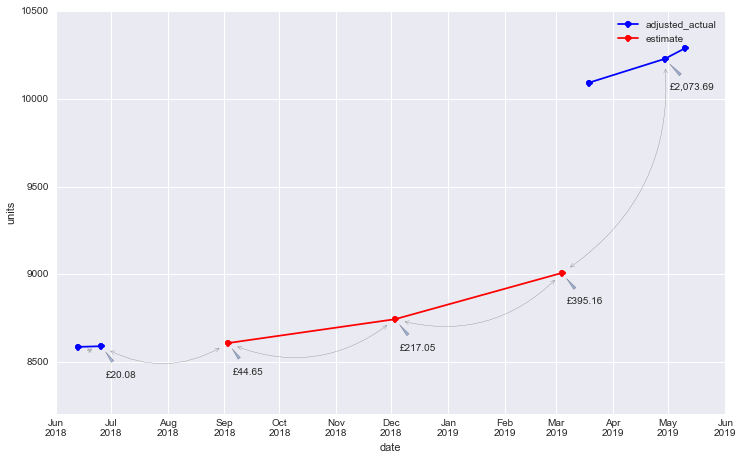

In [3]:
# plot
ax = df.plot(x='date', y=['adjusted_actual', 'estimate'], style=['bo-', 'ro-'], figsize=(12,8))
_ = ax.set_xlim([pd.Timestamp('2018-06-01'), pd.Timestamp('2019-06-01')])
_ = ax.set_ylim([8200, 10500])
ax.set_ylabel('units')
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b\n%Y'))
ax.xaxis.set_tick_params(which='major', labelbottom=False)
last_bp = (df.date[0], df.bill_reading[0])
for i, r in df.dropna(subset=['bill']).iterrows():
    ax.annotate('', (r.date, r.bill_reading), xytext = last_bp, 
        arrowprops = {'arrowstyle':'<->', 'connectionstyle':'arc3,rad=0.3', 'shrinkA':10, 'shrinkB':10, 'alpha':0.5}
        )
    ax.annotate(r.bill, (r.date, r.bill_reading), xytext = (5,-30), textcoords='offset points',
        arrowprops = {'arrowstyle':'wedge', 'shrinkA':7, 'shrinkB':7, 'alpha': 0.5})
    last_bp = (r.date, r.bill_reading)

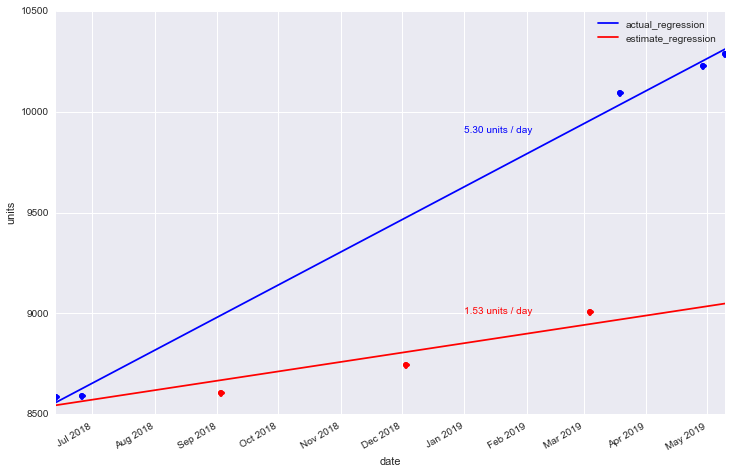

In [4]:
# simple linear regression
## actual readings - remove dates where there's no actual readings
actual_x = df[~df.adjusted_actual.isin([np.nan])].days.values
actual_y = df.adjusted_actual.dropna().values
actual_rate, actual_start = np.polyfit(actual_x, actual_y, 1)
## British Gas estimates - remove last three actual readings
estimate_x = df.days.values[:-3]
estimate_y = df.bill_reading.values[:-3]
estimate_rate, estimate_start = np.polyfit(estimate_x, estimate_y, 1)
## Regression data
regression_df = pd.DataFrame({
    'date': [df['date'].iloc[0], df['date'].iloc[-1]],
    'actual_regression': [actual_start, actual_rate * df['days'].iloc[-1] + actual_start],
    'estimate_regression': [estimate_start, estimate_rate * df['days'].iloc[-1] + estimate_start]
})
## plot graph with regression lines
ax2 = df.plot(x='date', y=['adjusted_actual', 'estimate'], style=['bo', 'ro'], figsize=(12,8), legend=False)
ax2.set_ylabel('units')
regression_df.plot(ax=ax2, x='date', style=['b', 'r'])
#actual_df.plot(ax=ax2, x='date', color='lightblue')
ax2.annotate('{:.2f} units / day'.format(actual_rate), (pd.Timestamp('2019-01-01'), 9900), color='blue')
#estimate_df.plot(ax=ax2, x='date', color='pink')
ax2.annotate('{:.2f} units / day'.format(estimate_rate), (pd.Timestamp('2019-01-01'), 9000), color='red')